# Assignment 6

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ Which mobile food vendor(s) sells at the most locations?

In [1]:
import sqlite3 as sql
db = sql.connect("sf_data.sqlite")
db.row_factory = sql.Row
import pandas as pd

In [37]:
#pd.read_sql("SELECT * FROM sqlite_master", db)

In [264]:
#db.close()
pd.read_sql("SELECT * FROM mobile_food_permits LIMIT 4", db)

In [12]:
pd.read_sql("SELECT * FROM mobile_food_locations LIMIT 4",db)

locationid                                LocationDescription  \
0      762182        TOWNSEND ST: 05TH ST to 06TH ST (400 - 499)   
1      437211      MISSOURI ST: 20TH ST to SIERRA ST (500 - 630)   
2      765880    17TH ST: SAN BRUNO AVE to UTAH ST (2200 - 2299)   
3      765690  CESAR CHAVEZ ST: EVANS AVE to KANSAS ST (2100 ...   

                Address   Latitude   Longitude  
0       444 TOWNSEND ST  37.774871 -122.398532  
1       555 MISSOURI ST  37.759304 -122.395902  
2          2222 17TH ST  37.765216 -122.406007  
3  2323 CESAR CHAVEZ ST  37.748801 -122.400552

In [13]:
pd.read_sql("SELECT * FROM mobile_food_schedule LIMIT 4",db)

locationid      permit DayOfWeek  EndHour  StartHour
0      305727  11MFF-0040        Mo       15         10
1      305727  11MFF-0040        Tu       15         10
2      305727  11MFF-0040        We       15         10
3      305727  11MFF-0040        Th       15         10

<p> mobile_food_schedule has locationid and permit. We are able to merge information in mobile_food_permits and  mobile_food_locations by using this table.</p>

In [2]:
# create a new table with information of Vendors type and location
db.execute(
    "CREATE TABLE Vendor_loc AS "
    "SELECT S.permit, S.locationid, P.FacilityType "
    "FROM mobile_food_schedule AS S INNER JOIN mobile_food_permits AS P ON  S.permit=P.permit"
)

In [166]:
#db.execute("DROP TABLE Vendor_loc")

In [36]:
pd.read_sql("SELECT * FROM Vendor_loc LIMIT 4",db)

permit  locationid FacilityType
0  11MFF-0040      305727        Truck
1  11MFF-0040      305727        Truck
2  11MFF-0040      305727        Truck
3  11MFF-0040      305727        Truck

In [40]:
# count the distinct locationid for each facility type, higher counts means that this facility type occurs in more locations
pd.read_sql("SELECT COUNT(DISTINCT(locationid)) AS loc_count, FacilityType FROM Vendor_loc GROUP BY FacilityType",db)

loc_count FacilityType
0          5         None
1         65    Push Cart
2        609        Truck

<p> We know from the table above that Truck sells at the most locations. </p>

__Exercise 1.2.__ Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

In [4]:
# Make Jupyter to automatically display matplotlib plots.
%matplotlib inline
# Make plots larger.
import matplotlib.pyplot as plt
import geopandas as gpd
import pysal as ps
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
tls.set_credentials_file(username='63xinxin', api_key='mDtzarbNAj4XSeno8Bu2')
plt.rcParams['figure.figsize'] = (12, 12)

In [21]:
pd.read_sql("SELECT * FROM zillow LIMIT 4",db)

RegionName                 Date  ZriPerSqft_AllHomes  \
0       94109  2010-11-01 00:00:00                3.156   
1       94110  2010-11-01 00:00:00                2.566   
2       94122  2010-11-01 00:00:00                2.168   
3       94080  2010-11-01 00:00:00                1.666   

   MedianSoldPricePerSqft_AllHomes  PriceToRentRatio_AllHomes  \
0                         675.1913                      19.14   
1                         599.6785                      18.10   
2                         495.4432                      17.99   
3                         369.5538                      18.31   

   Turnover_AllHomes  
0             6.0771  
1             5.4490  
2             2.4198  
3             3.8757

<h3>Q1. Which parts of the city are the most and least expensive? </h3>

<h4> In space aspect</h4>

In [191]:
# the price of house data should stored in Zillow
medp = pd.read_sql("SELECT AVG(MedianSoldPricePerSqft_AllHomes) AS MedianPrice, RegionName FROM zillow GROUP BY RegionName", db)

In [192]:
medp.head()

MedianPrice  RegionName
0   375.629802       94080
1   626.417276       94102
2   604.009929       94103
3  1336.128581       94104
4   798.257824       94105

In [4]:
# there is only zipcode information in zillow. We need to merge it with city name
#zillow = pd.read_sql("SELECT * FROM zillow", db)

In [4]:
medp.dtypes

MedianPrice    int64
RegionName     int64
dtype: object

In [193]:

zips = gpd.read_file("zipcodes/cb_2015_us_zcta510_500k.shp")
zips = zips.rename(columns={"ZCTA5CE10":"RegionName"})
zips.dtypes

AFFGEOID10    object
ALAND10        int64
AWATER10       int64
GEOID10       object
RegionName    object
geometry      object
dtype: object

In [194]:
sf = gpd.read_file("SF/geo_export_fbb4e1da-9b27-4620-ad7a-0cf514236ce5.shp")

In [182]:
base = sf
#sf.plot()

In [195]:
zips["RegionName"] = zips["RegionName"].apply(pd.to_numeric)

In [196]:
medpzip = pd.merge(medp,zips,on="RegionName",how="inner")

In [197]:
medpzip.head() # the first row is the information of South San Francisco

MedianPrice  RegionName      AFFGEOID10   ALAND10  AWATER10 GEOID10  \
0   375.629802       94080  8600000US94080  26636696    282925   94080   
1   626.417276       94102  8600000US94102   1732305         0   94102   
2   604.009929       94103  8600000US94103   3518316         0   94103   
3  1336.128581       94104  8600000US94104    200857         0   94104   
4   798.257824       94105  8600000US94105    952915    208000   94105   

                                            geometry  
0  POLYGON ((-122.469009 37.650404, -122.458997 3...  
1  POLYGON ((-122.429929 37.777909, -122.426829 3...  
2  POLYGON ((-122.426418 37.765784, -122.426402 3...  
3  POLYGON ((-122.404613 37.793565, -122.401315 3...  
4  POLYGON ((-122.403456 37.787776, -122.401939 3...

In [198]:
medpzip = medpzip.iloc[1:,:] # the 1st is row, 2nd is column

In [199]:
# change to gpd geo dataframe
medpzip = gpd.GeoDataFrame( medpzip, geometry = medpzip["geometry"] )
medpzip['coords'] = medpzip['geometry'].apply(lambda x: x.representative_point().coords[:])
medpzip['coords'] = [coords[0] for coords in medpzip['coords']]

C:\Users\Xin~\Anaconda3\lib\site-packages\geopandas\plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


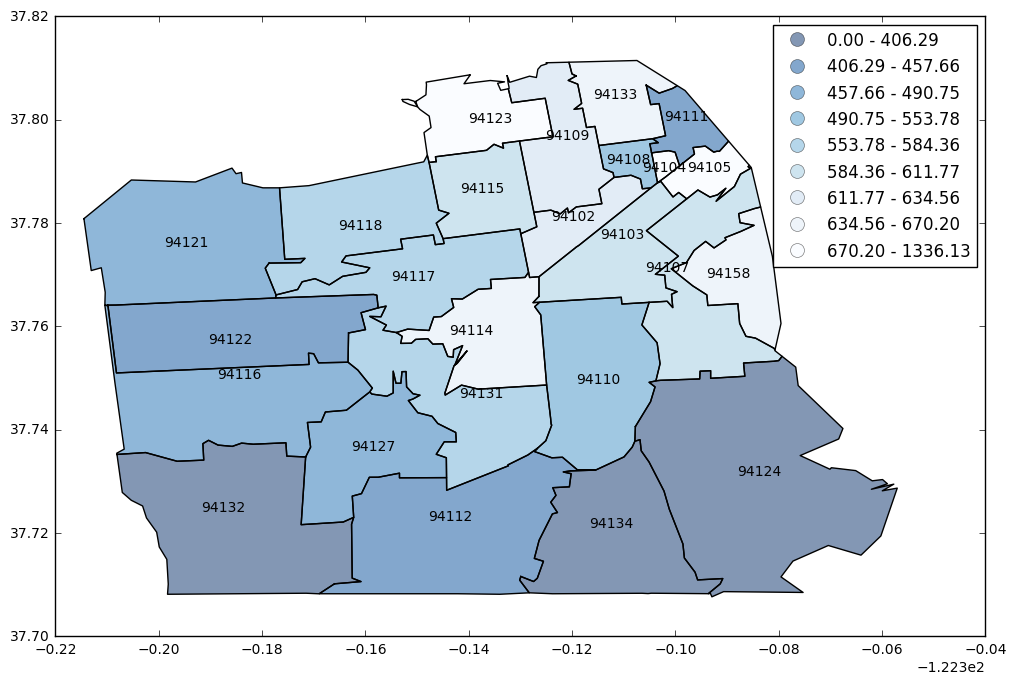

In [200]:
#import pysal as ps # in order to show the scale and use "scheme=..."
medpzip.plot(column='MedianPrice',scheme='QUANTILES',k=9, legend=True,colormap=plt.cm.Blues_r)
for idx, row in medpzip.iterrows():
    plt.annotate(s=row['RegionName'], xy=row['coords'],
                 horizontalalignment='center')

<p><b> Plot 1</b></p>

<P> According to the colored map we know that places in the Northeastern part of San Francisco have higher all home housing price. Areas with zipcodes 94105, 94104 and 94123 have the highest sold price. Area in the South and Western part of SF have the least price. The lowest ones are area with zipcode 94134, 94124 and 94132. This result is reasonable because Northeastern part of SF is the are with finance district and have larger population density compare with other places. </p>

<h4> In time aspect </h4>

In [94]:
zillow = pd.read_sql("SELECT * FROM zillow",db)
zillow["Year"] = zillow.Date.str.extract("([0-9]{4}).*",expand=False)
zillow.to_sql("zillow_y",db)

In [227]:
pd.read_sql("SELECT * FROM zillow_y  LIMIT 4",db)

index  RegionName                 Date  ZriPerSqft_AllHomes  \
0      0       94109  2010-11-01 00:00:00                3.156   
1      1       94110  2010-11-01 00:00:00                2.566   
2      2       94122  2010-11-01 00:00:00                2.168   
3      3       94080  2010-11-01 00:00:00                1.666   

   MedianSoldPricePerSqft_AllHomes  PriceToRentRatio_AllHomes  \
0                         675.1913                      19.14   
1                         599.6785                      18.10   
2                         495.4432                      17.99   
3                         369.5538                      18.31   

   Turnover_AllHomes  Year  
0             6.0771  2010  
1             5.4490  2010  
2             2.4198  2010  
3             3.8757  2010

In [228]:
zillow_y = pd.read_sql("SELECT AVG(MedianSoldPricePerSqft_AllHomes) AS Price, Year FROM zillow_y GROUP BY Year ",db)

In [229]:
trace = go.Scatter(
x = zillow_y.Year,
y = zillow_y["Price"],
mode="markers")
data = [trace]
layout = dict(title="Median Sold Price of AllHomes from 2010 to 2017",
             xaxis = dict(title = "Year"),
             yaxis = dict(title = "Median Sold Price"))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='SoldPrice 2010-2017')

<p> There is an obvious increasing trend of median all homes sold price. Even though there is a slightly decreasing trend from 2007 to 2011 because of economic depression.</p>

<h3>Q2.  Which parts of the city are the most dangerous (and at what times)?</h3>

<p> Find out the most dangerous city 

In [6]:
crime = pd.read_sql("SELECT * FROM crime",db)
crime["Datetime"] = crime.Datetime.str.strip()

In [68]:
crime.dtypes

IncidntNum      int64
Category       object
Descript       object
DayOfWeek      object
Datetime       object
PdDistrict     object
Resolution     object
Address        object
Lon           float64
Lat           float64
Year           object
dtype: object

In [7]:
# extract the year from datetime variable
# ways to transfer object to string....can't find it. But i find this: very useful ~~~
# http://pandas.pydata.org/pandas-docs/stable/text.html
crime["Year"] = crime.Datetime.str.extract("([0-9]{4}).*",expand=False)

In [57]:
#db.execute("DROP TABLE crime_y")

In [8]:
# create crime table with year information in it.
crime.to_sql("crime_y",db)

<p>We should transfer Datetime into datetime format and create tables group by year. For each year find out the avg number of incidents for each location (group by location).</p>

<h4> In time aspect </h4>

In [92]:
pd.read_sql("SELECT DISTINCT(Year) FROM crime_y ORDER BY Year ",db)

Year
0  2010
1  2011
2  2012
3  2013
4  2014
5  2015
6  2016
7  2017

<p> There are total crime data ranging from 2011 to 2017. </p>

In [232]:
# create a table for each year
crime_year = pd.read_sql("SELECT SUM(IncidntNum) AS IncidntNumSum, Year FROM crime_y GROUP BY Year ORDER BY Year",db)
crime_year.Year = crime_year.Year.apply(lambda x: pd.to_numeric(x))

In [99]:
crime_year["Year"]
#crime_year["IncidntNumSum"]

0    2010
1    2011
2    2012
3    2013
4    2014
5    2015
6    2016
7    2017
Name: Year, dtype: int64

In [102]:
crime_year["Year"]

0    2010
1    2011
2    2012
3    2013
4    2014
5    2015
6    2016
7    2017
Name: Year, dtype: int64

In [233]:
# Create random data with numpy
trace = go.Scatter(
x = crime_year.Year,
y = np.log(crime_year["IncidntNumSum"]),
mode="markers")
data = [trace]
layout = dict(title="Crime Incidents from 2010 to 2017",
             xaxis = dict(title = "Year"),
             yaxis = dict(title = "Log of Crime Incidents"))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Criminal 2010-2017')

<p>From the plot above we know that there is an increasing trend for criminal incidents. Since the data for 2017 is incomplete, we do not take it into account. </p>

<h4> In space aspect </h4>

In [234]:
crime_address = pd.read_sql("SELECT SUM(IncidntNum) AS IncidntNumSum, Address, Lon, Lat FROM crime GROUP BY Address",db)

In [22]:
import shapely.geometry as geom

def pdtoGeo(df):
    lonlat = [geom.Point(lon, lat) for lon, lat in zip(df.Lon, df.Lat)]
    df = df.drop(["Lon", "Lat"], axis = 1) #drop column
    df = gpd.GeoDataFrame(df, geometry = lonlat, crs = {'init' :'epsg:4326'})
    return df


In [ ]:
crime_address = pdtoGeo(crime_address)
crime_address.geometry.head()

In [47]:
crime_address.head()

IncidntNumSum             Address  \
0      533922559  0 Block of 10TH AV   
1    29107577159  0 Block of 10TH ST   
2      166249239  0 Block of 11TH AV   
3     8088667111  0 Block of 11TH ST   
4     2055016945  0 Block of 12TH AV   

                                      geometry  
0  POINT (-122.469054591066 37.78662859238371)  
1    POINT (-122.41725760507 37.7762695066166)  
2   POINT (-122.470123606846 37.7865816707738)  
3   POINT (-122.417930265052 37.7749028724693)  
4   POINT (-122.471194406641 37.7865324808919)

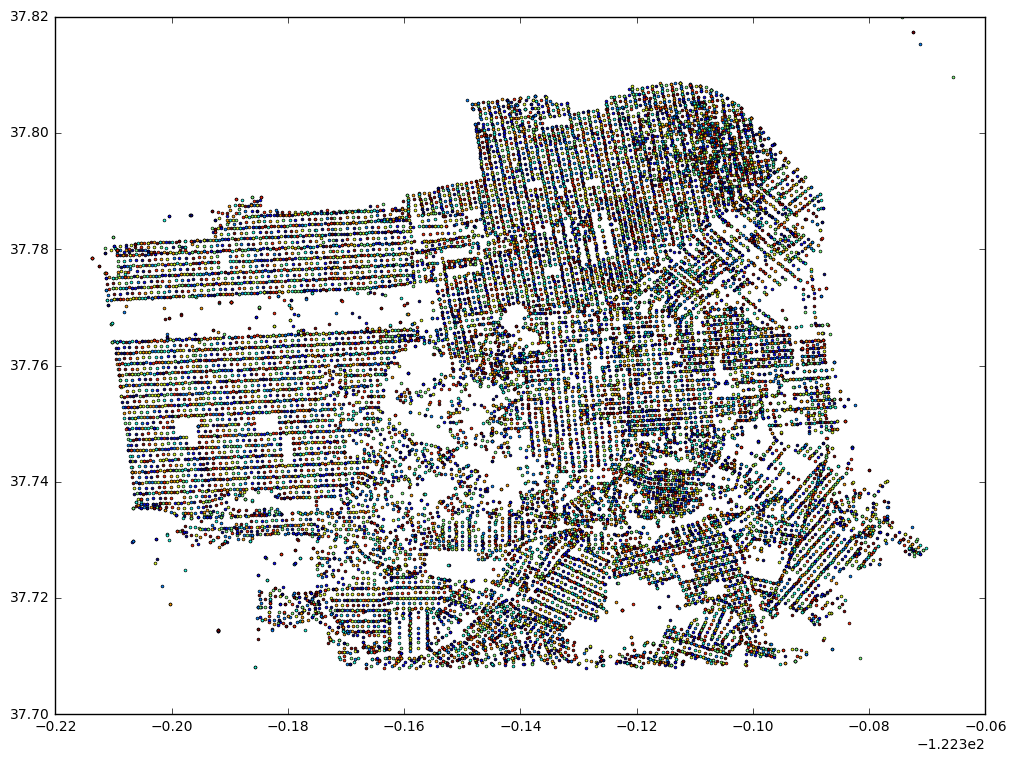

In [243]:
#import pysal as ps # in order to show the scale and use "scheme=..."
#import pysal as ps 
#import shapely.geometry as geom
crime_address.plot()

C:\Users\Xin~\Anaconda3\lib\site-packages\geopandas\plotting.py:225: FutureWarning:

'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)



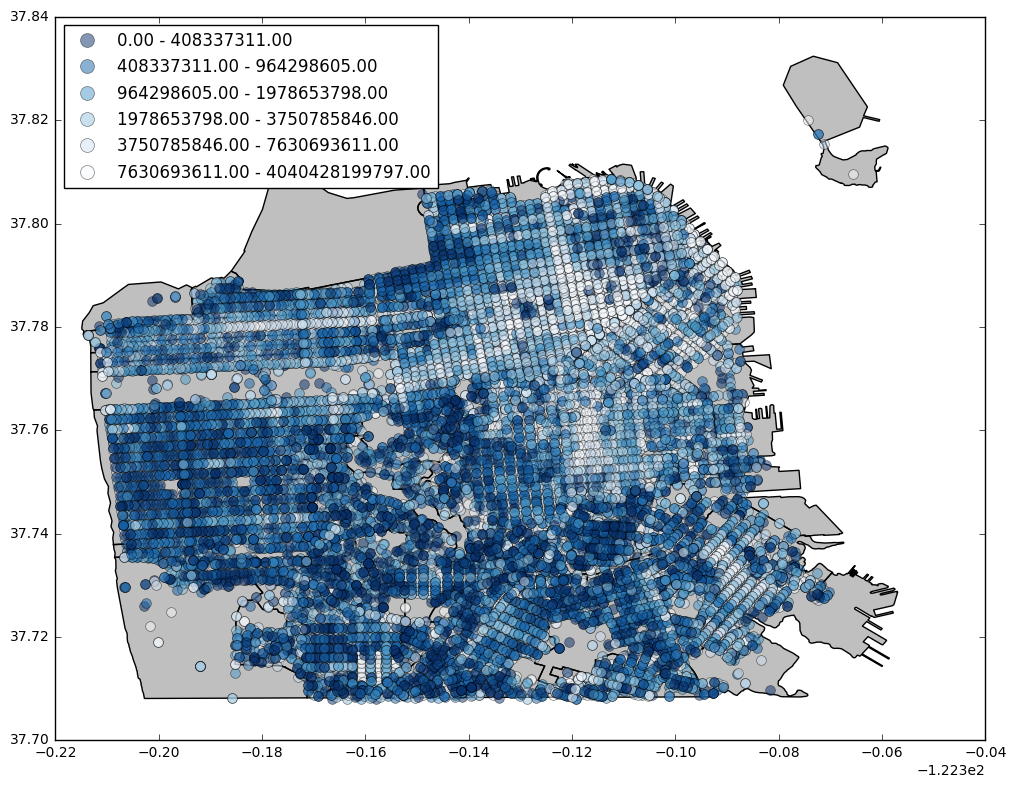

In [240]:
import pysal as ps 
base = sf.plot(color="grey")
crime_address.plot(ax=base,column="IncidntNumSum",marker="o",markersize =7,scheme='QUANTILES',k=6, legend=True,colormap=plt.cm.Blues_r,alpha=0.5)

<p>This plot shows all the positions that had ever happend crime incidents. The color stands for the number of total incidents happened at that place.</p>

<p> The plot above is the overall crime incidents across 2010-2017 in San Francisco. Sine 2016 has the highest criminal rate. Let us take a look at the districution of crime incidents in 2016 in San Francisco.</p>

In [47]:
crime2016 = pd.read_sql("SELECT SUM(IncidntNum) AS IncidntNumSum, Address, Lon, Lat FROM crime_y WHERE Year = 2016 GROUP BY Address ",db)
crime2016 = pdtoGeo(crime2016)

C:\Users\Xin~\Anaconda3\lib\site-packages\geopandas\plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


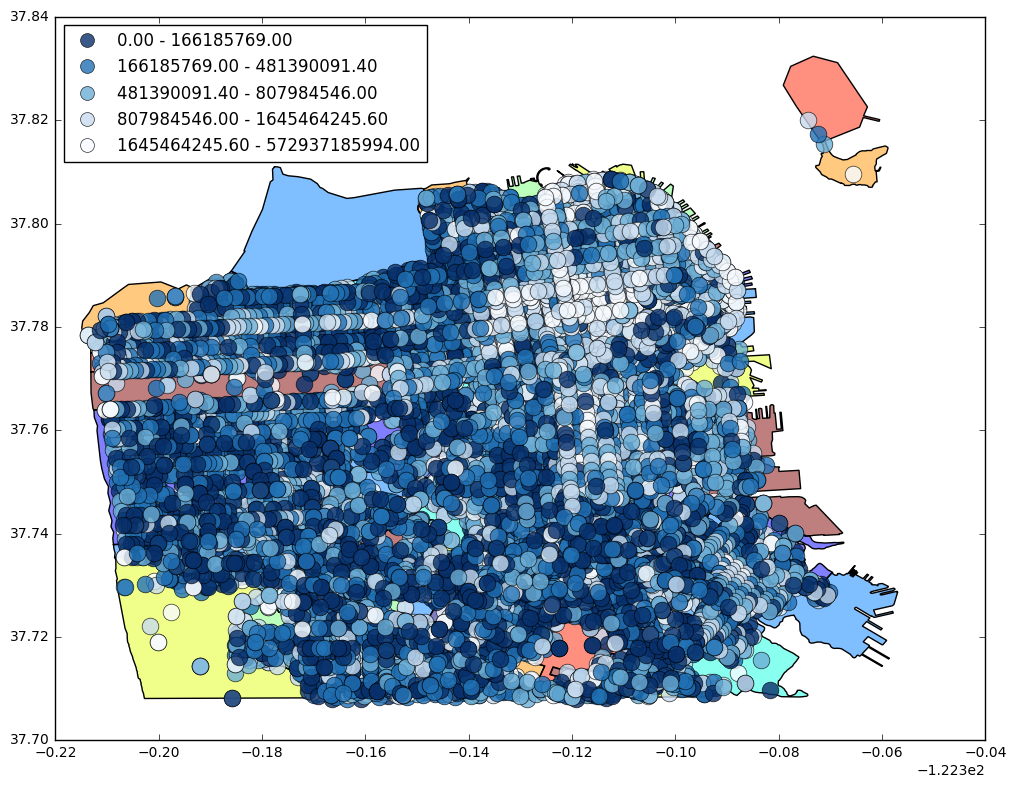

In [50]:
crime2016 = pd.read_sql("SELECT SUM(IncidntNum) AS IncidntNumSum, Address, Lon, Lat FROM crime_y WHERE Year = 2016 GROUP BY Address ",db)
crime2016 = pdtoGeo(crime2016)
#import pysal as ps 
base = sf.plot()
crime2016.plot(ax=base,column="IncidntNumSum",marker="o",markersize = 12,scheme='QUANTILES',k=5, legend=True,colormap=plt.cm.Blues_r,alpha=0.8)

In [51]:
crime2016.dtypes

IncidntNumSum     int64
Address          object
geometry         object
dtype: object

<p> From the plot above we know that the distribution of crime incidents in 2016 is similar with the distribution for all those years. Thus we can conclude that the most dangerous part in San Francisco is in the Southeastern part.  </p>

<h3>Q3. Are noise complaints and mobile food vendors related?</h3>

In [164]:
pd.read_sql("SELECT * FROM noise LIMIT 4",db)

CaseID                         Type  \
0  5130305        other_excessive_noise   
1  6446138  amplified_sound_electronics   
2  5929789        other_excessive_noise   
3  5659943        other_excessive_noise   

                                        Address     Neighborhood  \
0        Not associated with a specific address             None   
1  Intersection of CLINTON PARK and GUERRERO ST  Mission Dolores   
2       1301 48TH AVE, SAN FRANCISCO, CA, 94122     Outer Sunset   
3  736 LEAVENWORTH ST, SAN FRANCISCO, CA, 94109   Lower Nob Hill   

              Datetime        Lat         Lon  
0  2015-09-25 00:29:33        NaN         NaN  
1  2016-10-21 13:20:18  37.769148 -122.424475  
2  2016-06-01 11:38:59  37.762047 -122.508365  
3  2016-03-13 01:18:27  37.787983 -122.414943

In [165]:
#mobile_food_permits  mobile_food_schedule
pd.read_sql("SELECT * FROM mobile_food_locations LIMIT 4",db)

locationid                                LocationDescription  \
0      762182        TOWNSEND ST: 05TH ST to 06TH ST (400 - 499)   
1      437211      MISSOURI ST: 20TH ST to SIERRA ST (500 - 630)   
2      765880    17TH ST: SAN BRUNO AVE to UTAH ST (2200 - 2299)   
3      765690  CESAR CHAVEZ ST: EVANS AVE to KANSAS ST (2100 ...   

                Address   Latitude   Longitude  
0       444 TOWNSEND ST  37.774871 -122.398532  
1       555 MISSOURI ST  37.759304 -122.395902  
2          2222 17TH ST  37.765216 -122.406007  
3  2323 CESAR CHAVEZ ST  37.748801 -122.400552

<h4> In space aspect </h4>

<p> Draw a plot that different colors presents vendor and noise complaints in a map</p>

In [36]:
# change column name of mobile_food_locations
#db.execute("ALTER TABLE mobile_food_locations RENAME COLUMN Latitude TO Lat")
# I cannot use RENAME COLUMN in sqlite3 (not possible to add or delete a column): http://stackoverflow.com/questions/4007014/alter-column-in-sqlite
db.execute("ALTER TABLE mobile_food_locations ADD Lat float64 ")
db.execute("UPDATE mobile_food_locations SET Lat= Latitude")
#db.execute("ALTER TABLE mobile_food_locations DROP Latitude")
db.execute("ALTER TABLE mobile_food_locations ADD Lon float64 ")
db.execute("UPDATE mobile_food_locations SET Lon= Longitude")
# create a new column as indicator
db.execute("ALTER TABLE mobile_food_locations ADD Indicator Character String")
db.execute("UPDATE mobile_food_locations SET Indicator= 'Vendor'")

In [16]:
# also add an indicator in noise
db.execute("ALTER TABLE noise ADD Indicator Character String")
db.execute("UPDATE noise SET Indicator= 'Noise'")

In [17]:
pd.read_sql("SELECT * FROM mobile_food_locations LIMIT 4",db)
#ALTER TABLE Persons DROP COLUMN DateOfBirth

locationid                                LocationDescription  \
0      762182        TOWNSEND ST: 05TH ST to 06TH ST (400 - 499)   
1      437211      MISSOURI ST: 20TH ST to SIERRA ST (500 - 630)   
2      765880    17TH ST: SAN BRUNO AVE to UTAH ST (2200 - 2299)   
3      765690  CESAR CHAVEZ ST: EVANS AVE to KANSAS ST (2100 ...   

                Address   Latitude   Longitude Indicator  
0       444 TOWNSEND ST  37.774871 -122.398532    Vendor  
1       555 MISSOURI ST  37.759304 -122.395902    Vendor  
2          2222 17TH ST  37.765216 -122.406007    Vendor  
3  2323 CESAR CHAVEZ ST  37.748801 -122.400552    Vendor

In [18]:
pd.read_sql("SELECT * FROM noise LIMIT 4",db)

CaseID                         Type  \
0  5130305        other_excessive_noise   
1  6446138  amplified_sound_electronics   
2  5929789        other_excessive_noise   
3  5659943        other_excessive_noise   

                                        Address     Neighborhood  \
0        Not associated with a specific address             None   
1  Intersection of CLINTON PARK and GUERRERO ST  Mission Dolores   
2       1301 48TH AVE, SAN FRANCISCO, CA, 94122     Outer Sunset   
3  736 LEAVENWORTH ST, SAN FRANCISCO, CA, 94109   Lower Nob Hill   

              Datetime        Lat         Lon Indicator  
0  2015-09-25 00:29:33        NaN         NaN     Noise  
1  2016-10-21 13:20:18  37.769148 -122.424475     Noise  
2  2016-06-01 11:38:59  37.762047 -122.508365     Noise  
3  2016-03-13 01:18:27  37.787983 -122.414943     Noise

In [89]:
#vendor_loc = pd.read_sql("SELECT Longitude, Latitude, Indicator FROM mobile_food_locations",db)
vendor_loc = pd.read_sql("SELECT Lon, Lat, Indicator FROM mobile_food_locations",db)
#vendor_loc = vendor_loc.rename(columns={"Longitude":"Lon","Latitude":"Lat"})
noise_loc = pd.read_sql("SELECT Lon, Lat, Indicator FROM noise",db)

In [44]:
noise_loc.dtypes

Lon          float64
Lat          float64
Indicator     object
dtype: object

In [39]:
vendor_noise = pd.concat([vendor_loc,noise_loc])
vendor_noise = pdtoGeo(vendor_noise)

In [43]:
vendor_noise.head()

Indicator                                    geometry
0    Vendor  POINT (-122.398531708276 37.7748713162388)
1    Vendor  POINT (-122.395902231236 37.7593037663834)
2    Vendor  POINT (-122.406006972029 37.7652159489938)
3    Vendor  POINT (-122.400552458785 37.7488013777145)
4    Vendor  POINT (-122.416104892532 37.7678524427181)

In [41]:
vendor_noise.geometry.head()

0    POINT (-122.398531708276 37.7748713162388)
1    POINT (-122.395902231236 37.7593037663834)
2    POINT (-122.406006972029 37.7652159489938)
3    POINT (-122.400552458785 37.7488013777145)
4    POINT (-122.416104892532 37.7678524427181)
Name: geometry, dtype: object

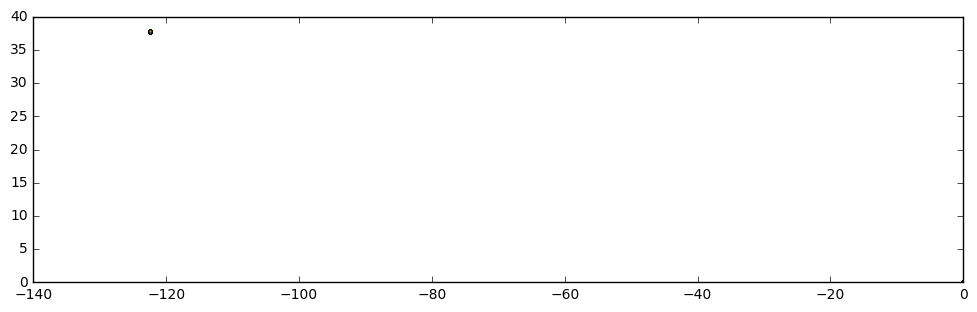

In [88]:
#base = sf.plot()
#noise_loc = pdtoGeo(noise_loc)
vendor_loc = pdtoGeo(vendor_loc)
#vendor_noise.plot(ax=base)
vendor_loc.plot()

<p> I can't find the reason for not being able to show all the points. All my codes and data are correct. Unable to debug.</p>

<p> There is an observation' lon and lat are equal to zero. Consider delete it. May be that is the reason</p>

In [90]:
vendor_loc = vendor_loc.loc[~(vendor_loc.Lat == 0)]

In [76]:
vendor_noise = pd.concat([vendor_loc,noise_loc])
vendor_noise = pdtoGeo(vendor_noise)

C:\Users\Xin~\Anaconda3\lib\site-packages\geopandas\plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


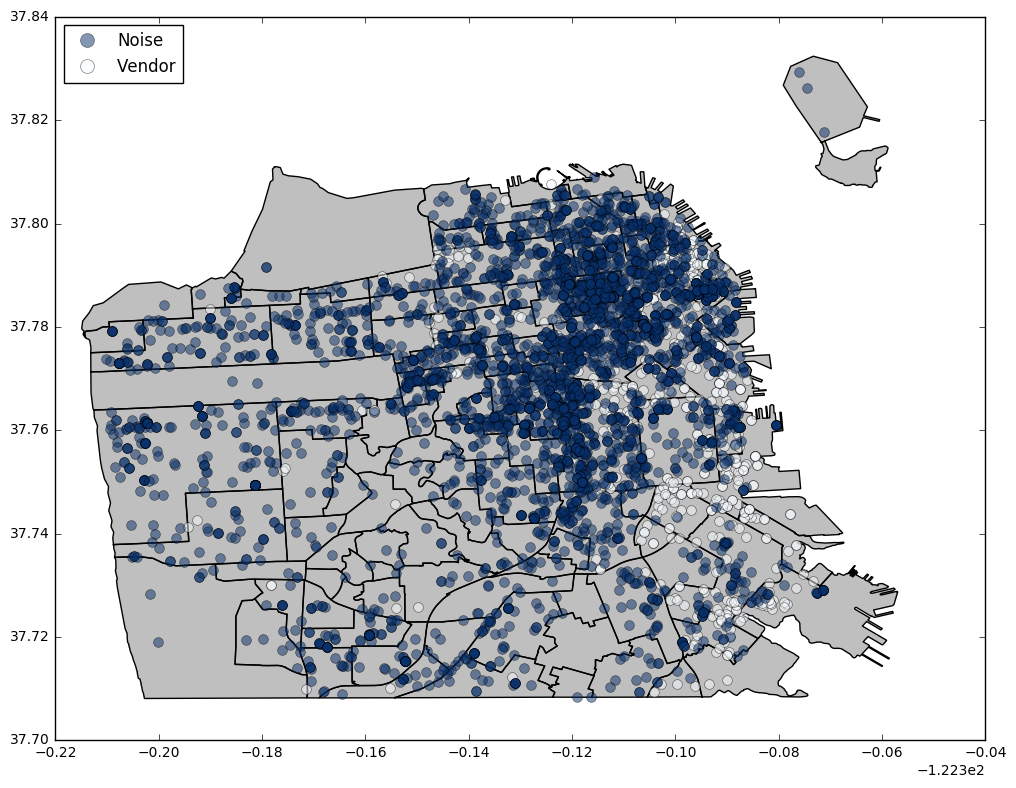

In [92]:
base = sf.plot(color="grey")
vendor_noise.plot(ax=base,column="Indicator",markersize=7,alpha=0.5,legend=True,colormap=plt.cm.Blues_r)

<p> It is not clear that whether vendor is overlapped by points from complaints. So I drawed a plot for vendor separately. From this plot we know that most of the vendors and noises are in the Northeastern part of SF. The reason for it may because of large population density in that area. But for other areas there is not obvious sign of close relationship between noise and vendors. The location of Noise complaints have much larger scope than location of vendors. </p>

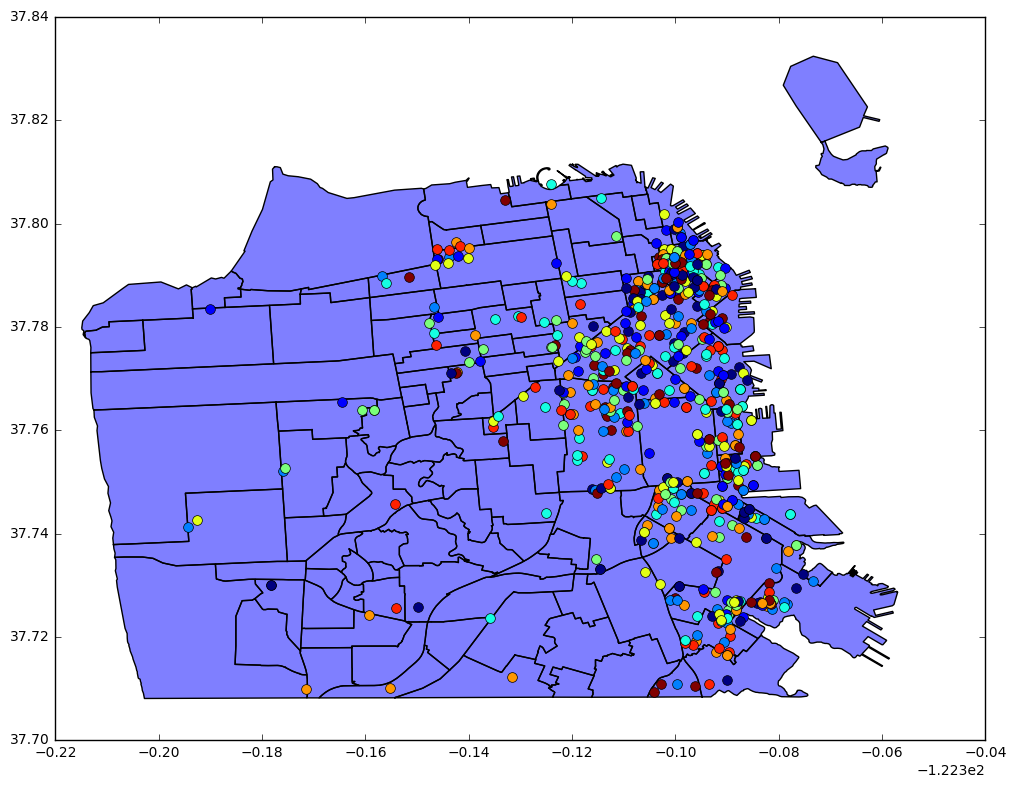

In [91]:
vendor_loc = pdtoGeo(vendor_loc)
base = sf.plot(color="blue")
vendor_loc.plot(ax=base,markersize=7,legend=True)

<p> From this plot we know that vendors most located in the left part of SF. By comparing this plot with the previous one with points for both noise and vendors, we can conclude that there is not close relationship between vendors and noise. Because there is not many noise complaints in the Southeastern part of SF which the spread of vendors are dense.</p>

<h4> In time aspect</h4>

<p> Since there is no strong correlation for vendors and noise in location aspects, we do not need to further discuss it in time aspect.</p>

<h3>Q4. What are the best times and places to find food trucks?</h3>

<p> The best places to find food trucks means we can easily find food trucks in that place. Or we can say that the truck density is large. The best times to find food trucks means that during that period of time the numbers of food trucks that are working is largest. So for this question, we first find the best place and then find the best time.</p> 

<h4> The best place </h4>

In [118]:
pd.read_sql("SELECT DISTINCT(FacilityType) FROM mobile_food_permits LIMIT 4",db)

FacilityType
0        Truck
1    Push Cart
2         None

In [108]:
# create table for Truck
db.execute("CREATE TABLE Truck AS "
          "SELECT * FROM mobile_food_permits WHERE FacilityType = 'Truck' ")
#pd.read_sql("SELECT * FROM mobile_food_permits LIMIT 4",db)

In [119]:
pd.read_sql("SELECT * FROM Truck LIMIT 4",db)

permit    Status         Applicant FacilityType  \
0  16MFF-0027  APPROVED    F & C Catering        Truck   
1  13MFF-0102   EXPIRED  Natan's Catering        Truck   
2  16MFF-0069  APPROVED     Munch A Bunch        Truck   
3  16MFF-0051  APPROVED   Park's Catering        Truck   

                                           FoodItems  PriorPermit  \
0  Cold Truck: Hot/Cold Sandwiches: Water: Soda: ...            1   
1  Burgers: melts: hot dogs: burritos:sandwiches:...            1   
2  Cold Truck: packaged sandwiches: pitas: breakf...            1   
3  Cold Truck: Hamburger: cheeseburgers: hot dogs...            1   

              Approved           Expiration  
0  2016-03-09 12:00:00  2017-03-15 12:00:00  
1  2013-04-12 12:00:00  2014-03-15 12:00:00  
2  2016-03-15 12:00:00  2017-03-15 12:00:00  
3  2016-03-15 12:00:00  2017-03-15 12:00:00

In [110]:
# combine time information
db.execute("CREATE TABLE Truck_schedule AS "
          "SELECT * FROM Truck AS T INNER JOIN mobile_food_schedule AS S ON T.permit = S.permit ")
#pd.read_sql("SELECT * FROM mobile_food_schedule LIMIT 4",db)

In [132]:
pd.read_sql("SELECT * FROM Truck_schedule LIMIT 4",db)

permit    Status       Applicant FacilityType  \
0  16MFF-0027  APPROVED  F & C Catering        Truck   
1  16MFF-0027  APPROVED  F & C Catering        Truck   
2  16MFF-0027  APPROVED  F & C Catering        Truck   
3  16MFF-0027  APPROVED  F & C Catering        Truck   

                                           FoodItems  PriorPermit  \
0  Cold Truck: Hot/Cold Sandwiches: Water: Soda: ...            1   
1  Cold Truck: Hot/Cold Sandwiches: Water: Soda: ...            1   
2  Cold Truck: Hot/Cold Sandwiches: Water: Soda: ...            1   
3  Cold Truck: Hot/Cold Sandwiches: Water: Soda: ...            1   

              Approved           Expiration  locationid    permit:1 DayOfWeek  \
0  2016-03-09 12:00:00  2017-03-15 12:00:00      762178  16MFF-0027        Fr   
1  2016-03-09 12:00:00  2017-03-15 12:00:00      762178  16MFF-0027        Fr   
2  2016-03-09 12:00:00  2017-03-15 12:00:00      762178  16MFF-0027        Mo   
3  2016-03-09 12:00:00  2017-03-15 12:00:00      762178  16MFF-0027        Mo   

   EndHour  StartHour  
0        9          6  
1       13          0  
2        9          6  
3       13          0

<p> Obiviously, we need to use mobile_food_locations table for locations information. </p>

In [130]:
pd.read_sql("SELECT * FROM mobile_food_locations LIMIT 4",db)

locationid                                LocationDescription  \
0      762182        TOWNSEND ST: 05TH ST to 06TH ST (400 - 499)   
1      437211      MISSOURI ST: 20TH ST to SIERRA ST (500 - 630)   
2      765880    17TH ST: SAN BRUNO AVE to UTAH ST (2200 - 2299)   
3      765690  CESAR CHAVEZ ST: EVANS AVE to KANSAS ST (2100 ...   

                Address   Latitude   Longitude Indicator        Lat  \
0       444 TOWNSEND ST  37.774871 -122.398532    Vendor  37.774871   
1       555 MISSOURI ST  37.759304 -122.395902    Vendor  37.759304   
2          2222 17TH ST  37.765216 -122.406007    Vendor  37.765216   
3  2323 CESAR CHAVEZ ST  37.748801 -122.400552    Vendor  37.748801   

          Lon  
0 -122.398532  
1 -122.395902  
2 -122.406007  
3 -122.400552

In [136]:
# combine location and schedule
pd.read_sql("SELECT S.locationid, S.DayOfWeek, S.EndHour, S.StartHour, L.Latitude, L.Longitude, L.Address "
            "FROM Truck_schedule AS S INNER JOIN mobile_food_locations AS L ON L.locationid = S.locationid ORDER BY L.Latitude LIMIT 4",db)

locationid DayOfWeek  EndHour  StartHour  Latitude  Longitude  \
0      762185        Fr       11         10       0.0        0.0   
1      762185        Mo       11         10       0.0        0.0   
2      762185        Th       11         10       0.0        0.0   
3      762185        Tu       11         10       0.0        0.0   

            Address  
0  900 MINNESOTA ST  
1  900 MINNESOTA ST  
2  900 MINNESOTA ST  
3  900 MINNESOTA ST

<p>We can see from the table above that there are lat and lon values equal to zero. But when I search those address in Google, they are actually located in SF. So consider correct those data.</p>

In [137]:
# number of lat == 0
pd.read_sql("SELECT COUNT(DISTINCT(L.Address)) AS Counts "
            "FROM Truck_schedule AS S INNER JOIN mobile_food_locations AS L ON L.locationid = S.locationid WHERE L.Latitude = 0",db)

Counts
0      40

<p>Since we do not have information of Lon and Lat for those locations and the amount of them is 40 which is small consider to the total amount of Trucks(609), I delete those locations directly.</p>

In [143]:
db.execute("CREATE TABLE Truck_sch_loc AS "
            "SELECT S.locationid, S.DayOfWeek, S.EndHour, S.StartHour, L.Latitude, L.Longitude, L.Address "
            "FROM Truck_schedule AS S INNER JOIN mobile_food_locations AS L ON L.locationid = S.locationid  WHERE L.Latitude != 0")

In [144]:
Truck = pd.read_sql("SELECT * FROM Truck_sch_loc",db)

In [147]:
Truck.loc[:15]

locationid DayOfWeek  EndHour  StartHour   Latitude   Longitude  \
0       762182        Fr       11         10  37.774871 -122.398532   
1       762182        Mo       11         10  37.774871 -122.398532   
2       762182        Th       11         10  37.774871 -122.398532   
3       762182        Tu       11         10  37.774871 -122.398532   
4       762182        We       11         10  37.774871 -122.398532   
5       437211        Fr       10          9  37.759304 -122.395902   
6       437211        Fr       13          0  37.759304 -122.395902   
7       437211        Mo       10          9  37.759304 -122.395902   
8       437211        Mo       13          0  37.759304 -122.395902   
9       437211        Th       10          9  37.759304 -122.395902   
10      437211        Th       13          0  37.759304 -122.395902   
11      437211        Tu       10          9  37.759304 -122.395902   
12      437211        Tu       13          0  37.759304 -122.395902   
13      437211        We       10          9  37.759304 -122.395902   
14      437211        We       13          0  37.759304 -122.395902   
15      765880        Fr        6          5  37.765216 -122.406007   

            Address  
0   444 TOWNSEND ST  
1   444 TOWNSEND ST  
2   444 TOWNSEND ST  
3   444 TOWNSEND ST  
4   444 TOWNSEND ST  
5   555 MISSOURI ST  
6   555 MISSOURI ST  
7   555 MISSOURI ST  
8   555 MISSOURI ST  
9   555 MISSOURI ST  
10  555 MISSOURI ST  
11  555 MISSOURI ST  
12  555 MISSOURI ST  
13  555 MISSOURI ST  
14  555 MISSOURI ST  
15     2222 17TH ST

In [141]:
Truck = Truck.rename(columns={"Longitude":"Lon","Latitude":"Lat"})
Truck = pdtoGeo(Truck)

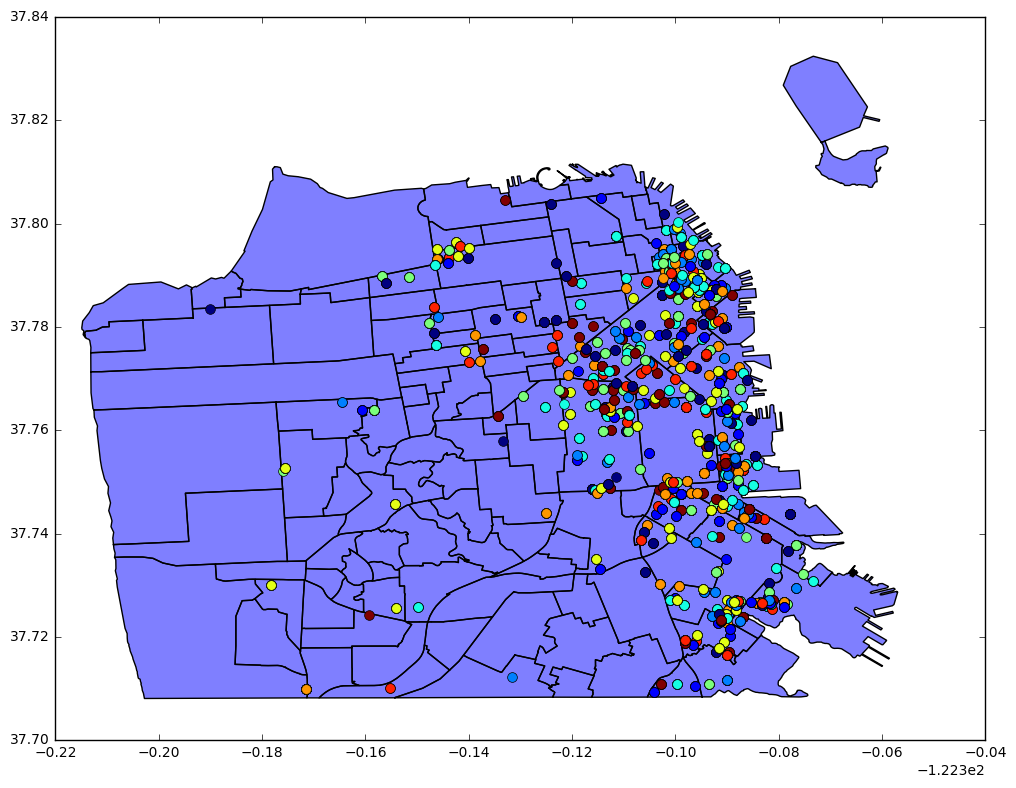

In [142]:
base = sf.plot(color="blue")
Truck.plot(ax=base,markersize=7,legend=True)

<P>This map with points presenting the location of trucks is pretty much the same as we drawed before for all the vendors. And refer to the map with zipcode on it we can know that the place with most Trucks is 94104. That area has financial district. The places nearby is Union Square.</p>

<h4> The best time </h4>

In [152]:
# find the location have the most vendor
pd.read_sql("SELECT COUNT(DayOfWeek) AS Fre_DayOfWeek , DayOfWeek FROM Truck_sch_loc GROUP BY DayOfWeek ORDER BY Fre_DayOfWeek",db)

Fre_DayOfWeek DayOfWeek
0             79        Su
1            103        Sa
2            528        Tu
3            530        Th
4            536        We
5            541        Fr
6            622        Mo

<P>  On Monday the number of Trucks that work is the largest. On Sunday the number of Trucks that work is the smallest.</p>

In [172]:
# combine the information of start and end hour.
# USE CAST() transfer numeric to string and use || to cancat string
db.execute("CREATE TABLE Truck_Dur AS "
            "SELECT CAST(StartHour AS TEXT)||'_'||CAST(EndHour AS TEXT) AS Duration FROM Truck_sch_loc")

In [174]:
pd.read_sql("SELECT * FROM Truck_Dur LIMIT 5",db)

Duration
0    10_11
1    10_11
2    10_11
3    10_11
4    10_11

In [177]:
pd.read_sql("SELECT COUNT(Duration) AS Fre_Dur , Duration FROM Truck_Dur GROUP BY Duration ORDER BY Fre_Dur DESC LIMIT 10",db)

Fre_Dur Duration
0      498     9_10
1      376    10_11
2      257     0_13
3      249      8_9
4      246     11_0
5      161      7_8
6       77    13_14
7       74      6_7
8       65    14_15
9       51    10_15

<P> From the table above we know that most of the Trucks work from 9 to 10. There are also many Trucks that work from 10 to 11. Thus, the best time for find truck is 9 to 11 on Monday. </p>

<h3>Q5. Is there location relationship between housing prices and school?</h3>

<p> Let us learn more about the information in school. It is a table with school name, category, general type.</p>

In [178]:
pd.read_sql("SELECT * FROM schools LIMIT 5",db)

Name Entity  LowerGrade  UpperGrade GradeRange  \
0         Alamo Elementary School  SFUSD           0           5        K-5   
1      Alvarado Elementary School  SFUSD           0           5        K-5   
2             Aptos Middle School  SFUSD           6           8        6-8   
3  Argonne Early Education School  SFUSD          -2           0      PK-TK   
4       Argonne Elementary School  SFUSD           0           5        K-5   

         Category  LowerAge  UpperAge GeneralType  \
0  USD Grades K-5         5        10          PS   
1  USD Grades K-5         5        10          PS   
2  USD Grades 6-8        11        13          PS   
3     USD PreK/TK         3         5          PS   
4  USD Grades K-5         5        10          PS   

                                    Address        Lat         Lon  
0     250 23RD AVE, San Francisco, CA 94121  37.783005 -122.482300  
1  625 DOUGLASS ST, San Francisco, CA 94114  37.753681 -122.438194  
2    105 APTOS AVE, San Francisco, CA 94127  37.729672 -122.465782  
3     750 16TH AVE, San Francisco, CA 94118  37.773968 -122.474060  
4     680 18TH AVE, San Francisco, CA 94121  37.775307 -122.476311

In [210]:
# distinct Category
pd.read_sql("SELECT COUNT(Category) AS Fre_Catogory, Category FROM schools GROUP BY Category ORDER BY Fre_Catogory desc",db)

Fre_Catogory                                       Category
0            304                          Independent / Private
1             45                                 USD Grades K-5
2             18                                USD Grades 9-12
3             14                                 USD Grades 6-8
4             10                     Community College District
5              9                                     USD PreK-5
6              7                                 USD Grades K-8
7              6                             USD Charter School
8              5                           USD PreK, Grades K-5
9              4                                       USD PreK
10             4                                  USD PreK/TK-5
11             3                              USD County School
12             2                                USD Grades 6-12
13             2                                USD Grades PK-8
14             2                         USD PreK-5, Grades K-5
15             2                                    USD PreK/TK
16             1                     USD Charter School; PreK-5
17             1                                 USD Grades K-4
18             1                         USD Grades K-5, PreK-5
19             1                                     USD PreK-4
20             1                         USD PreK-4, Grades K-5
21             1  USD PreK-5                                   
22             1                                     USD PreK-8
23             1                                  USD PreK/TK-4

In [211]:
# distinct GeneralType
pd.read_sql("SELECT COUNT(GeneralType) AS Fre_GeneralType, GeneralType FROM schools GROUP BY GeneralType ORDER BY Fre_GeneralType",db)

Fre_GeneralType GeneralType
0               10          CC
1              127          PS
2              141         IND
3              167         CDC

In [213]:
# Entity
pd.read_sql("SELECT COUNT(Entity) AS Fre_Entity, Entity FROM schools GROUP BY Entity ORDER BY Fre_Entity",db)

Fre_Entity   Entity
0          10    SFCCD
1         131    SFUSD
2         304  Private

<p> We can make a map that different colors in the map presents the value of median allhome sold price and points on the maps are schools. The colors of each points presents for the value of the school's ....</p>

In [202]:
school = pd.read_sql("SELECT * FROM schools",db)

In [203]:
school = pdtoGeo(school)

C:\Users\Xin~\Anaconda3\lib\site-packages\geopandas\plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


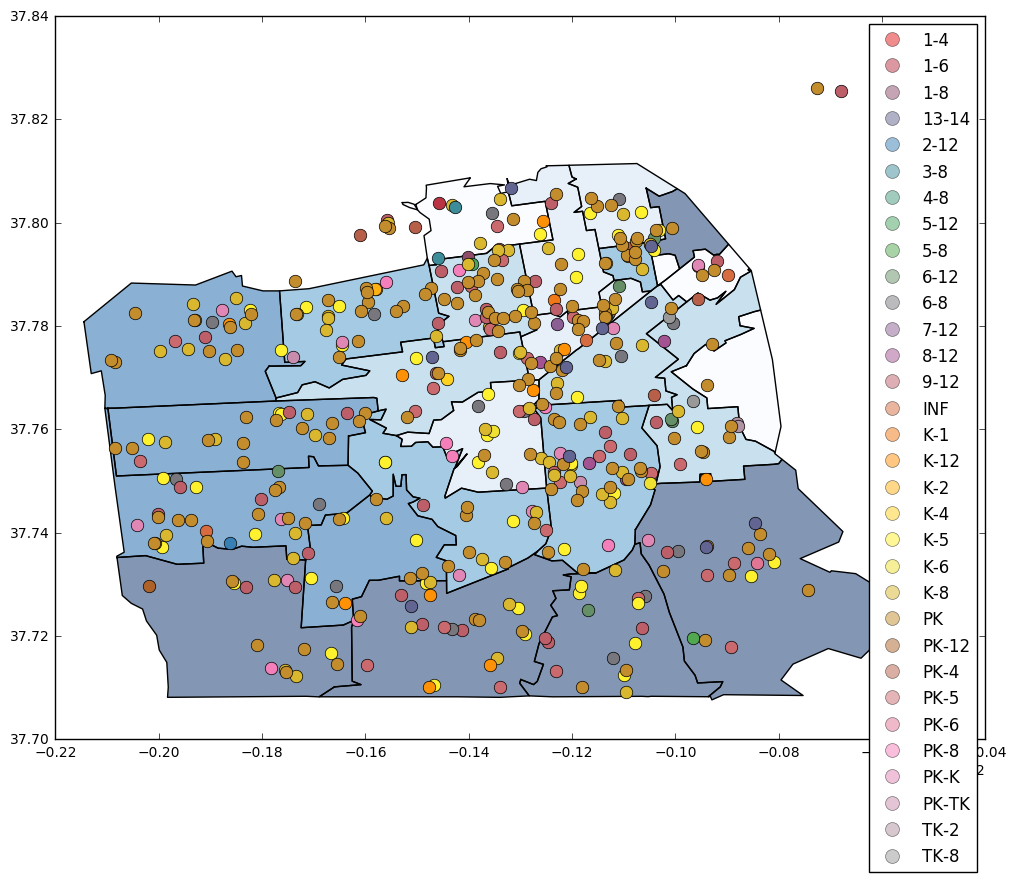

In [208]:
#GradeRange
base = medpzip.plot(column='MedianPrice',scheme='QUANTILES',k=6, colormap=plt.cm.Blues_r)
school.plot(ax=base, column="GradeRange", legend=True,markersize=9)

<P>There is no difference for the location of schools with different GradeRange. Overall schools are mostly located in the Northeastern part of SF.</p>

C:\Users\Xin~\Anaconda3\lib\site-packages\geopandas\plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


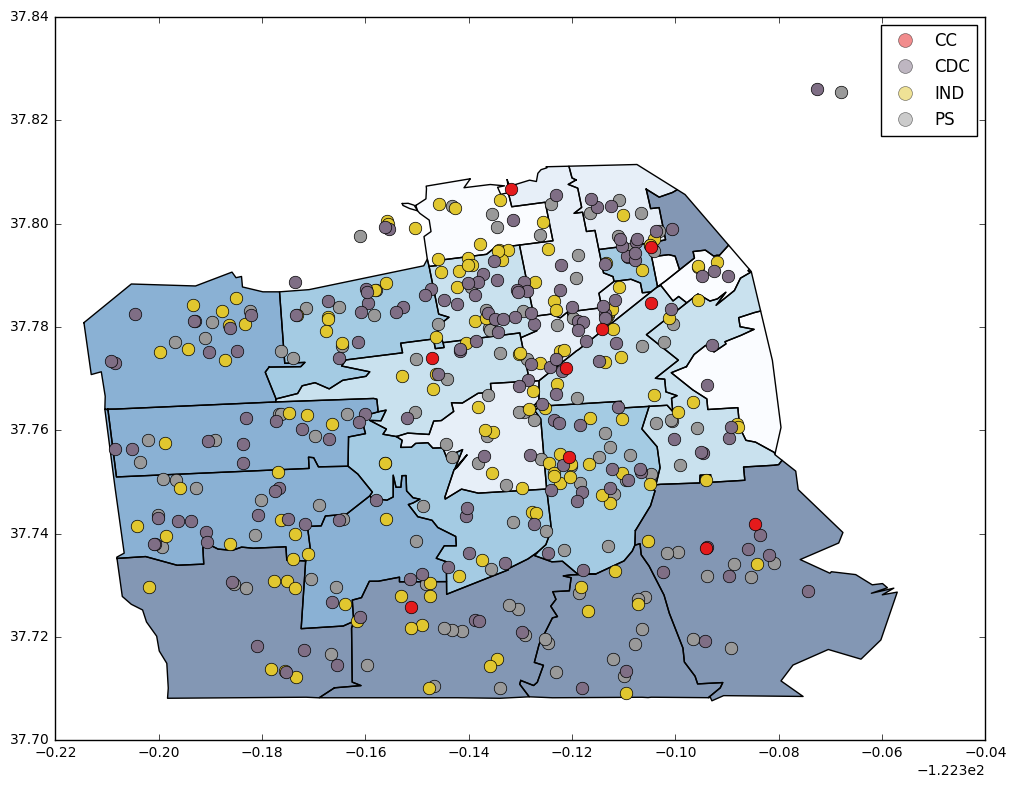

In [212]:
#GradeRange
base = medpzip.plot(column='MedianPrice',scheme='QUANTILES',k=6, colormap=plt.cm.Blues_r)
school.plot(ax=base, column="GeneralType", legend=True,markersize=9)

<P>School with GradeRange being "CC" are most located in the Northeastern part of SF. There are several of them located in the area with low housing price. </p>  

C:\Users\Xin~\Anaconda3\lib\site-packages\geopandas\plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


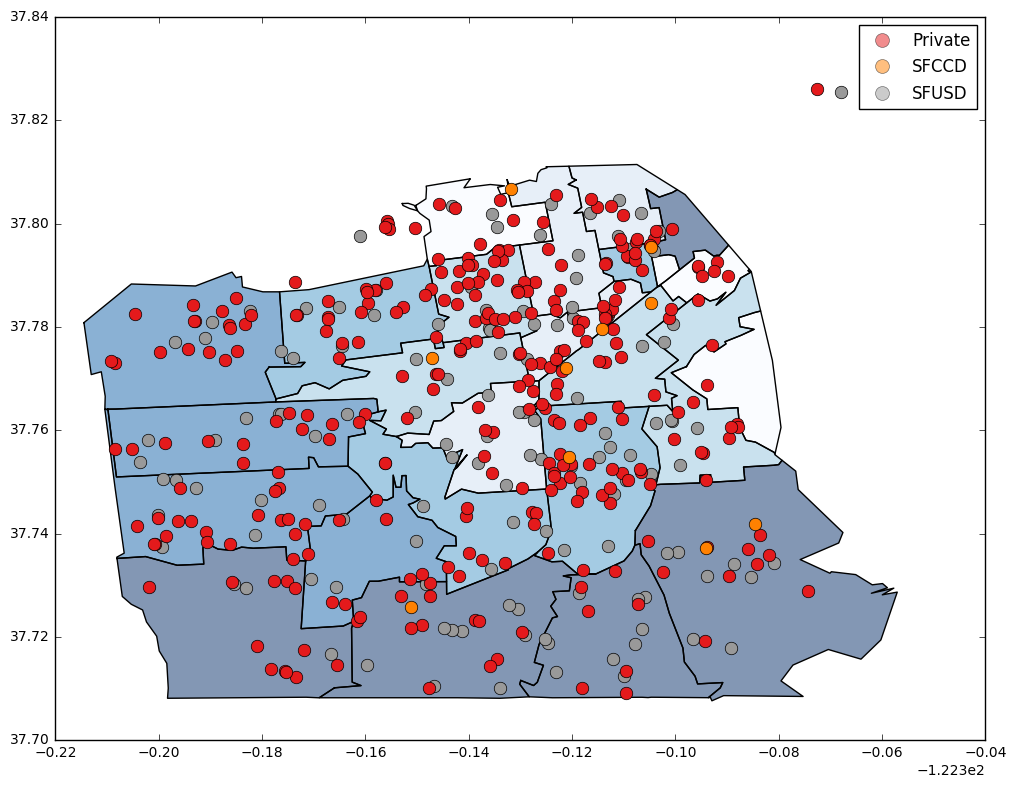

In [214]:
base = medpzip.plot(column='MedianPrice',scheme='QUANTILES',k=6, colormap=plt.cm.Blues_r)
school.plot(ax=base, column="Entity", legend=True,markersize=9)

<p>This plot shows similar results that most school are located in the Northeastern part of SF. In these parts of SF, house price is also higher. So we can conclude that there are somewhat relationship for schools and house price. If we have data of school ratings, we may be able to see more obivious relationship between schools and house price.</p> 